# This program predicts the last 20 (you can customize this) rows in a dependent data it loads. 

## What needs to be done next
1. Improve the prediction accuracy
<br> We need to find the optimal combinatino of n_input (see the code), the number of neurons in the LSTM layer, the number of epochs.
<br>
<br> 
2. Incorporate metrics (hit rate, IC)
<br>
<br>
3. Test if this program works with the whole data. Right now, I have only tested with smaller data.

This program is based on the following Udemy course's Section 9 Video 80-85: <br> https://www.udemy.com/share/101WWMB0Ydc1ZQRn4=/
<br> You are guaranteed the 30-day money-back, so you can buy and return it within 30 days.

Other articles I referenced to make this program:
<br> https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
<br> https://qiita.com/ta1nakamura/items/11b53669ce48219d6475
<br> https://www.dlology.com/blog/how-to-use-keras-timeseriesgenerator-for-time-series-data/

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tqdm import tqdm 
import warnings
warnings.filterwarnings(action = 'once')

In [8]:
# Importing the dataset
fileNames = ["metaData", "Symbol0 2"]
frames = []
for index, fileName in tqdm(enumerate(fileNames)):
    frames.append(dd.read_csv(fileName + ".csv", sep=",", sample = 2000000))

2it [00:00, 30.50it/s]


In [9]:
# X is the independent data, and y is the dependent data.
dataset = frames[1].iloc[:, 1:].to_dask_array(lengths=True) # "lengths=True" counts the number of rows in the frame.

In [10]:
# Convert dask arrays into numpy arrays
dataset = np.array(dataset)

In [11]:
# Split X and y into train and test
train = dataset[:40000, :]
# I just chose 14 because the first 13 rows are filled with 0 (NAs)
test = dataset[40000:, :]

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py:5851: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/daisuke/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibili

In [13]:
# Generate a TimeseriesGenerator, which learns the dependency between data
# In this case, the TimeseriesGenerator learns the dependency between scaled_X_train and scaled_y_train
n_input = 13 # 7 rows in scaled_X_train predicts 1 row in scaled_y_train
n_features = 21 # number of features—i.e. the number of colums of X

generator = TimeseriesGenerator(train, train, length=n_input, batch_size=500)
# "length": the number of the rows in scaled_X_train that are used for prediction
# "batch_size": the number of the labels (1 row in scaled_y_train)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [100]:
# Create a neural network model
model = Sequential()

# Add a LSTM layer to the neural network. 150 is the number of neurons in the layer. You need to play around with the number to find the best one. But 100 is a good number to try first.
model.add(LSTM(150, activation = 'relu', input_shape=(n_input, n_features)))
# Add a normal neural network layer, which contains y.shape[1] neurons
model.add(Dense(21))
# Loss function (cost function) is mse(Mean squared error)
model.compile(loss='accuracy', optimizer='adam')

ValueError: Unknown loss function:accuracy

In [90]:
# Show the shape of the neural network model we just created
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 300)               386400    
_________________________________________________________________
dense_3 (Dense)              (None, 21)                6321      
Total params: 392,721
Trainable params: 392,721
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Fit the model to the TimeseriesGenerator 30 times
model.fit_generator(generator,epochs=10)

Epoch 1/10
80/80 [==============================] - 15s 184ms/step - loss: 0.0179
Epoch 2/10
80/80 [==============================] - 15s 186ms/step - loss: 0.0132
Epoch 3/10
80/80 [==============================] - 15s 181ms/step - loss: 0.0129
Epoch 4/10
80/80 [==============================] - 15s 187ms/step - loss: 0.0128
Epoch 5/10
80/80 [==============================] - 15s 187ms/step - loss: 0.0128
Epoch 6/10
80/80 [==============================] - 16s 194ms/step - loss: 0.0128
Epoch 7/10
80/80 [==============================] - 15s 191ms/step - loss: 0.0126
Epoch 8/10
80/80 [==============================] - 15s 191ms/step - loss: 0.0128
Epoch 9/10
80/80 [==============================] - 15s 186ms/step - loss: 0.0126
Epoch 10/10
80/80 [==============================] - 15s 185ms/step - loss: 0.0126


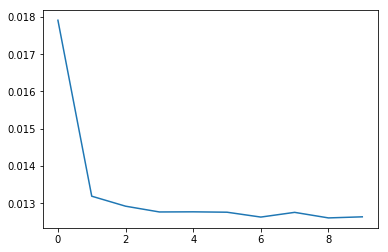

In [92]:
# Display how the loss decreases after each epoch
loss = model.history.history['loss']
epochs = range(len(loss))

plt.plot(epochs,loss)
plt.show()

In [93]:
# This variable holds predicitons
test_predictions = [] 

# Use last n_input points from the training set as a current_batch
first_eval_batch = train[-n_input:, :]
current_batch = first_eval_batch.reshape(1, n_input, n_features)
# Reshape so that the shape of first_eval_batch matches that of X of TimeseriesGenerator

# Predict len(scaled_y_test) datapoints
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    # Store the current prediction
    test_predictions.append(current_pred)
    
    # Update the current batch 
    current_batch = np.append(current_batch[:,1:,:], [[test[i, :]]], axis=1)
    #  axis = 1 means that [[current_pred] will be added to the second dimension of current_batch[:,1:,:]

In [94]:
# Predicted rows
df_pred = pd.DataFrame(test_predictions)
pred = df_pred.iloc[:, 0]

In [95]:
# Original rows in the dependent data
dependent = pd.DataFrame(dataset[40000:, 0])
df = pd.concat([pred, dependent], axis=1, sort=False)

In [97]:
pred = np.array(pred)
dependent = np.array(dependent)

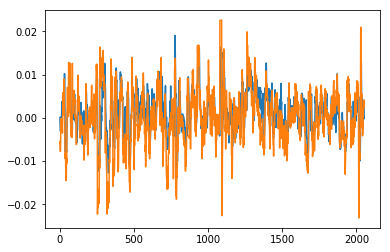

In [98]:
plt.plot(df)

In [99]:
counter = 0
for i in range(len(pred)):
    if i==len(pred)-1:
        break
    if (pred[i+1] - pred[i]) * (dependent[i+1] - dependent[i]) >= 0:
        counter = counter + 1
print(counter)
print(len(dependent))

1030
2054
